# RL and Advanced DL: Домашнее задание 1

## Части 2 и 3

Студент Черников Дмитрий, ML-32

In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from collections import defaultdict
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from tqdm import tqdm

from gym import error, spaces, utils
from gym.utils import seeding
from gym.envs.registration import register, registry
from gym.envs.toy_text.blackjack import *

np.set_printoptions(precision=6, suppress=True)

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [2]:
env = gym.make('Blackjack-v0', natural=True)
env

# Часть вторая, удвоенная

- 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

- 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [3]:
class BlackjackDoublingEnv(BlackjackEnv):
    def __init__(self, natural=True, sab=False):
        self.natural = natural
        super().__init__(self)
        self.action_space = spaces.Discrete(3)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2:
            # draw new card
            observation, reward, done, info = super().step(1)
            if not done:
                # if not busted then stand
                observation, reward, done, info = super().step(0)
            return observation, reward*2, done, info
        else:
            return super().step(action)

setattr(gym.envs.toy_text.blackjack, "BlackjackDoublingEnv", BlackjackDoublingEnv)
    
if 'BlackjackDoubling-v0' in registry.env_specs:
    del registry.env_specs['BlackjackDoubling-v0']
    
gym.envs.register(
    id='BlackjackDoubling-v0',
    entry_point='gym.envs.toy_text.blackjack:BlackjackDoublingEnv',
)

'BlackjackDoublingEnv' in dir(gym.envs.toy_text.blackjack)

True

In [4]:
# Test envifonment
env = gym.make('BlackjackDoubling-v0')

frame = env.reset()
reward = 0.0
is_done = False

for i in range(3):
    display((f"episode{i}", frame, reward, is_done))
    while not is_done:
        frame, reward, is_done, _ = env.step(2)
        display((f"episode{i}", frame, reward, is_done))
    env.close()

('episode0', (10, 10, False), 0.0, False)

('episode0', (12, 10, False), -2.0, True)

('episode1', (12, 10, False), -2.0, True)

('episode2', (12, 10, False), -2.0, True)

In [5]:
EPISODES = 1_000_000

N_STATES=32
N_ACTIONS=3

DIALER=17
SHORTFALL=12

class BaselineStrategy:
    """
    Тривиальная стратегия - не добирать.
    """
    def __init__(self, n_states=N_STATES, n_actions=N_ACTIONS):
        self.n_states, self.n_actions = n_states, n_actions
        self.states, self.actions, self.rewards = [], [], []
        
        self.V = defaultdict(float)
        self.RetS = defaultdict(int)
        self.Q = defaultdict(lambda: [np.random.uniform() for _ in range(n_actions)])
        self.RetSA = defaultdict(lambda: [0 for _ in range(n_actions)])
        
    def __str__(self):
        return "BaselineStrategy"
    
    def new_episode(self):
        self.states, self.rewards, self.actions = [], [], []
        
    def action(self, state):
        return 0
    
    def collect(self, state, action, reward, state_next):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
    def first_visit_mc(self):
        # first visit Monte Carlo estimation 
        G = 0
        for t in range(len(self.states)-1, -1, -1):
            S, A, R = self.states[t], self.actions[t], self.rewards[t]
            G += R
            if S not in self.states[:t]:
                self.RetS[S] += 1
                self.V[S] += (G - self.V[S]) / self.RetS[S]
                self.RetSA[S][A] += 1
                self.Q[S][A] += (G - self.Q[S][A]) / self.RetSA[S][A]


In [6]:
def run_episode(strategy, env):
    # reset states, actions, rewards
    strategy.new_episode()

    env.reset()

    reward = 0.0
    is_done = False
    while not is_done:
        state = env._get_obs()
        action = strategy.action(state)
        observation, reward, is_done, _ = env.step(action)
        # append states, actions, rewards
        strategy.collect(state, action, reward, observation)
        
    env.close()
    return reward


In [9]:
def first_visit_mc_estimation(strategy,
                              env=gym.make('Blackjack-v0', natural=True),
                              n_episodes=10000,
                              random_seed=None):
    
    if random_seed is not None:
        env.seed(random_seed)
        env.action_space.seed(random_seed)
    np.random.seed(random_seed)
    
    rewards = []
    for i in range(n_episodes):
        reward = run_episode(strategy, env)
        rewards.append(reward)
        strategy.first_visit_mc()

    return np.true_divide(np.cumsum(rewards), np.arange(n_episodes) + 1)

In [10]:
# collection of strategies
strats = {}

def run_estimation(strategy,
                   env=gym.make('Blackjack-v0', natural=True),
                   n_episodes=EPISODES,
                   strats=strats,
                   display_result=True,
                   min_rewards=-1.0):
    
    #run estimation
    wins = first_visit_mc_estimation(strategy, env=env, n_episodes=n_episodes)
    
    # add to result dataframe
    strats[str(strategy)] = { "strategy": strategy, "result": wins[-1], "wins": wins}
    
    # display results
    if display_result:
        display(f"{strategy}: result = {wins[-1]}")
            
    # plot avg rewards
    if wins[-1] >= min_rewards:
        plt.plot(wins, label=strategy)
        
    return wins

In [12]:
class DoublingStrategy(BaselineStrategy):
    """
    Простая стратегия - все время удваивать
    """
    
    def __init__(self, n_states=N_STATES, n_actions=N_ACTIONS):
        super().__init__(n_states, n_actions)
        
    def __str__(self):
        return f"DoublingStrategy"
    
    def action(self, state):
        return 2

'BaselineStrategy: result = -0.1650955'

'DoublingStrategy: result = -0.739528'

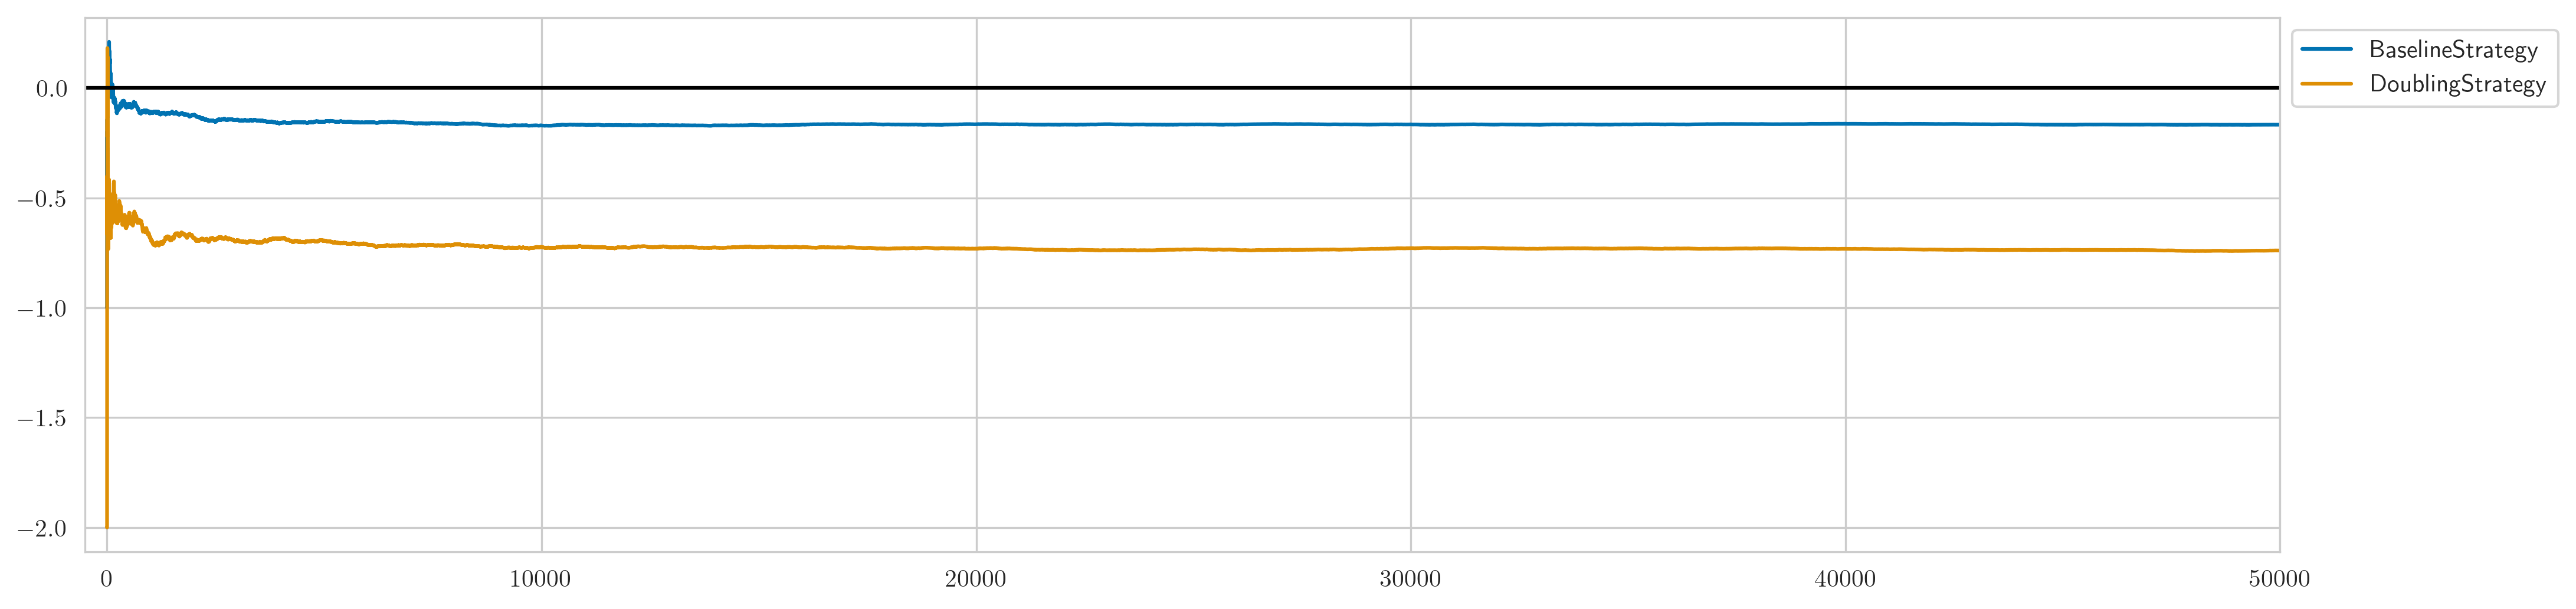

In [30]:
strats2 = {}

plt.figure(figsize=(16,4))

baseline_strategy2 = BaselineStrategy(n_actions=3)
baseline_strategy2_wins = run_estimation(baseline_strategy2,
                                         env=gym.make('BlackjackDoubling-v0'),
                                         strats=strats2)

doubling_strategy2 = DoublingStrategy(n_actions=3)
doubling_strategy2_wins = run_estimation(doubling_strategy2,
                                         env=gym.make('BlackjackDoubling-v0'),
                                         strats=strats2)

plt.axhline(y=0.0, color='black')
plt.xlim((-500, 50000))
#plt.ylim((-0.3, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Стратегии обучения с подкреплением из первой части


In [31]:
class MCControlStrategy(BaselineStrategy):
    """
    Monte Carlo control with exploring starts
    """
    
    def __init__(self, seed=None, n_states=N_STATES, n_actions=N_ACTIONS):
        super().__init__(n_states=n_states, n_actions=n_actions)
        self.seed = seed
        
        np.random.seed(seed)
        self.Q = defaultdict(lambda: [np.random.uniform() for _ in range(n_actions)])
        
    def __str__(self):
        return f"MCControlStrategy(seed={self.seed})"

    def action(self, state):
        return np.argmax(self.Q[state])

In [32]:
class SoftMCControlStrategy(MCControlStrategy):
    """
    Monte Carlo control with soft strategies
    """
    def __init__(self, eps=0.95, seed=None, n_states=N_STATES, n_actions=N_ACTIONS):
        super().__init__(seed=seed, n_states=n_states, n_actions=n_actions)
        self.eps = eps

    def __str__(self):
        return f"SoftMCControlStrategy(eps={self.eps}, seed={self.seed})"

    def action(self, state):
        return np.argmax(self.Q[state]) if np.random.uniform() < self.eps else np.random.randint(self.n_actions)

In [33]:
class SarsaStrategy:
    """
    Sarsa стратегия.
    """
    def __init__(self, eps=0.9, alpha=0.9, gamma=0.9, seed=None, n_states=N_STATES, n_actions=N_ACTIONS):
        self.n_states, self.n_actions = n_states, n_actions
        self.eps, self.alpha, self.gamma, self.seed = eps, alpha, gamma, seed        
        self.states, self.actions, self.rewards = [], [], []
        # first - always hit
        self.next_action = 1
        
        np.random.seed(seed)
        self.V = defaultdict(float)
        self.RetS = defaultdict(int)
        self.Q = defaultdict(lambda: [np.random.uniform() for _ in range(n_actions)])
        self.RetSA = defaultdict(lambda: [0 for _ in range(n_actions)])
                
    def __str__(self):
        return f"SarsaStrategy(eps={self.eps}, alpha={self.alpha}, gamma={self.gamma}, seed={self.seed})"
    
    def new_episode(self):
        self.states, self.rewards, self.actions = [], [], []
        # first - always hit
        self.next_action = 1
        
    def get_next_action(self, state):
        # eps-greedly strategy
        if np.random.uniform() < self.eps:
            action = np.argmax(self.Q[state])
        else:
            action = np.random.randint(self.n_actions)
        return action
        
    def action(self, state):
        # HACK
        return self.next_action if state[0] < 19 else 0
    
    def collect(self, state, action, reward, next_state):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
        self.next_action = self.get_next_action(next_state)
        Q_St_At = self.Q[state][action]
        Q_St_At = Q_St_At + self.alpha * (reward + self.gamma * self.Q[next_state][self.next_action] - Q_St_At)
        self.Q[state][action] = Q_St_At

    def first_visit_mc(self):
        # first visit Monte Carlo estimation 
        G = 0
        for t in range(len(self.states)-1, -1, -1):
            S, A, R = self.states[t], self.actions[t], self.rewards[t]
            G += R
            if S not in self.states[:t]:
                self.RetS[S] += 1
                self.V[S] += (G - self.V[S]) / self.RetS[S]


In [34]:
class QlearningStrategy:
    """
    Q-learning стратегия.
    """
    def __init__(self, eps=0.9, alpha=0.9, gamma=0.9, seed=None, n_states=N_STATES, n_actions=N_ACTIONS):
        self.n_states, self.n_actions = n_states, n_actions
        self.eps, self.alpha, self.gamma, self.seed = eps, alpha, gamma, seed        
        self.states, self.actions, self.rewards = [], [], []
        
        np.random.seed(seed)
        self.V = defaultdict(float)
        self.RetS = defaultdict(int)
        self.Q = defaultdict(lambda: [np.random.uniform() for _ in range(n_actions)])
        self.RetSA = defaultdict(lambda: [0 for _ in range(n_actions)])
                
    def __str__(self):
        return f"QlearningStrategy(eps={self.eps}, alpha={self.alpha}, gamma={self.gamma}, seed={self.seed})"
    
    def new_episode(self):
        self.states, self.rewards, self.actions = [], [], []
        
    def action(self, state):
        # eps-greedly strategy
        if np.random.uniform() < self.eps:
            action = np.argmax(self.Q[state])
        else:
            action = np.random.randint(self.n_actions)
        return action
    
    def collect(self, state, action, reward, next_state):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        
        Q_St_next = np.amax(self.Q[next_state])
        Q_St_At = self.Q[state][action]
        Q_St_At = Q_St_At + self.alpha * (reward + self.gamma * Q_St_next - Q_St_At)
        self.Q[state][action] = Q_St_At

    def first_visit_mc(self):
        # first visit Monte Carlo estimation 
        G = 0
        for t in range(len(self.states)-1, -1, -1):
            S, A, R = self.states[t], self.actions[t], self.rewards[t]
            G += R
            if S not in self.states[:t]:
                self.RetS[S] += 1
                self.V[S] += (G - self.V[S]) / self.RetS[S]


'BaselineStrategy: result = -0.1650955'

'DoublingStrategy: result = -0.739528'

100%|████████████████████████████████████████████| 3/3 [10:48<00:00, 216.14s/it]


,strategy,result,wins
"SoftMCControlStrategy(eps=0.97, seed=2)","SoftMCControlStrategy(eps=0.97, seed=2)",-0.0517,"[-1.0, -0.5, -0.6666666666666666, -0.75, -0.8,..."
"SoftMCControlStrategy(eps=0.97, seed=1)","SoftMCControlStrategy(eps=0.97, seed=1)",-0.05243,"[-2.0, -2.0, -1.0, -0.25, 0.0, -0.166666666666..."
"QlearningStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=1)","QlearningStrategy(eps=0.97, alpha=0.05, gamma=...",-0.056265,"[-2.0, -0.5, -1.0, -1.25, -1.4, -1.5, -1.57142..."
"QlearningStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=0)","QlearningStrategy(eps=0.97, alpha=0.05, gamma=...",-0.056352,"[-2.0, -2.0, -2.0, -2.0, -2.0, -1.833333333333..."
"QlearningStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=2)","QlearningStrategy(eps=0.97, alpha=0.05, gamma=...",-0.056368,"[-2.0, -2.0, -1.6666666666666667, -1.5, -1.6, ..."
"SoftMCControlStrategy(eps=0.97, seed=0)","SoftMCControlStrategy(eps=0.97, seed=0)",-0.056467,"[1.0, 1.5, 0.3333333333333333, 0.0, -0.2, -0.5..."
"SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=1)","SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.00...",-0.100566,"[-1.0, -1.0, -1.3333333333333333, -0.75, -0.8,..."
"SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=2)","SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.00...",-0.101138,"[0.0, -0.5, -0.3333333333333333, 0.25, -0.2, 0..."
"SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=0)","SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.00...",-0.10198,"[1.0, 1.0, 0.3333333333333333, 0.0, -0.4, -0.5..."
MCControlStrategy(seed=0),MCControlStrategy(seed=0),-0.112938,"[1.5, 1.75, 1.8333333333333333, 1.875, 1.7, 1...."


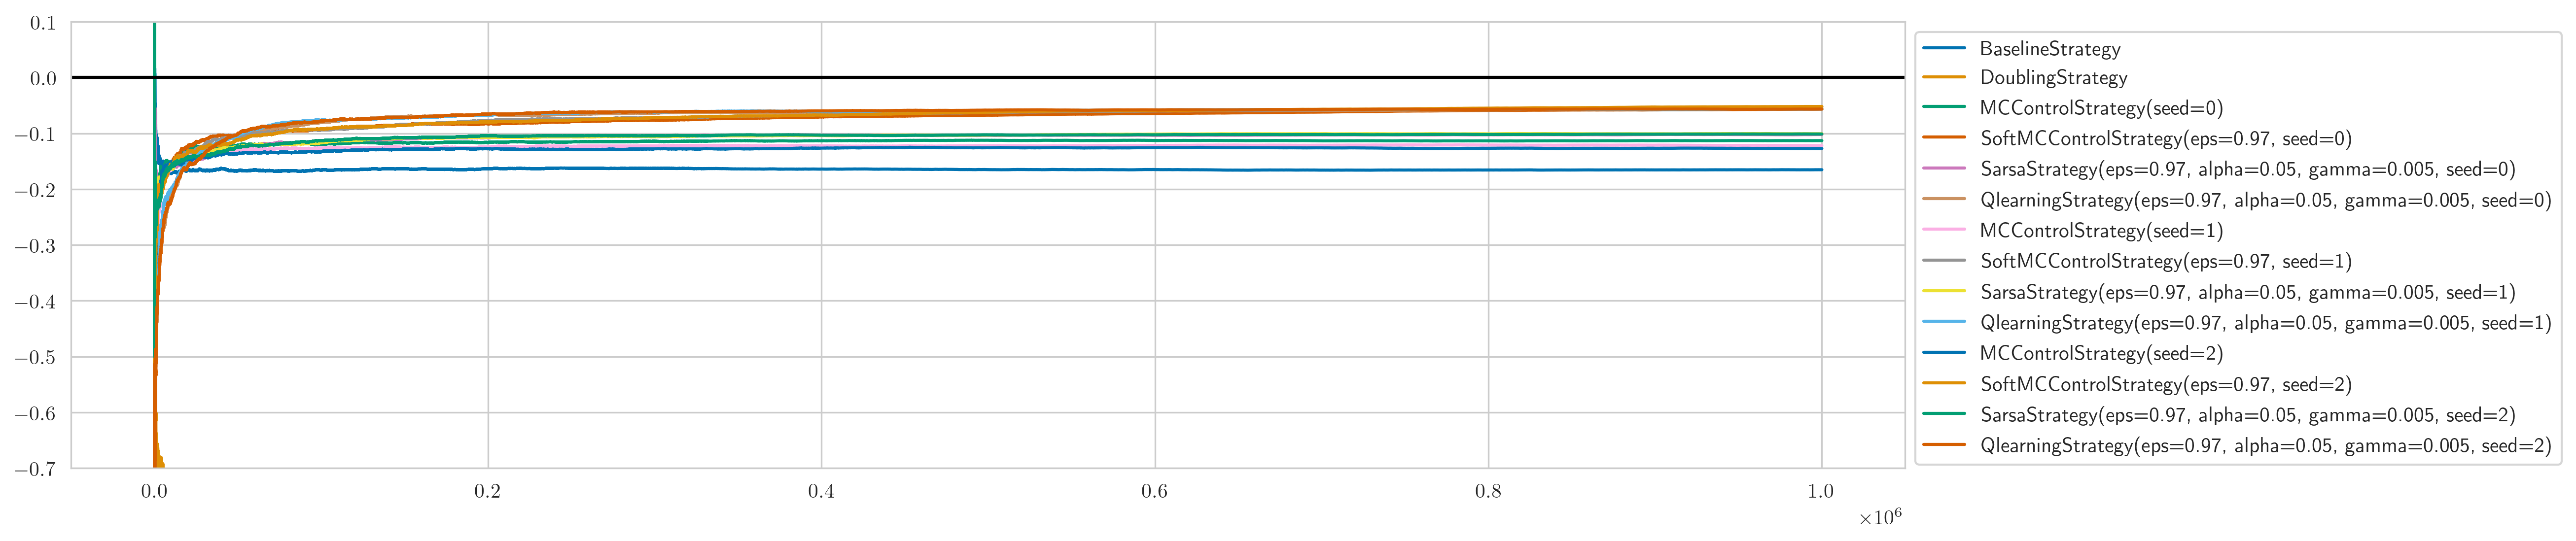

In [36]:
MAX_STRATEGIES = 3
MIN_REWARDS = -0.1

plt.figure(figsize=(16,4))

display(f"{baseline_strategy2}: result = {baseline_strategy2_wins[-1]}")
plt.plot(baseline_strategy2_wins, label=baseline_strategy2)

display(f"{doubling_strategy2}: result = {doubling_strategy2_wins[-1]}")
plt.plot(doubling_strategy2_wins, label=doubling_strategy2)


for i in tqdm(range(MAX_STRATEGIES)):
    strategy = MCControlStrategy(seed=i, n_actions=3)
    run_estimation(strategy, env=gym.make('BlackjackDoubling-v0'), display_result=False, strats=strats2)

    strategy = SoftMCControlStrategy(eps=0.97, seed=i, n_actions=3)
    run_estimation(strategy, env=gym.make('BlackjackDoubling-v0'), display_result=False, strats=strats2)

    strategy = SarsaStrategy(eps=0.97, seed=i, alpha=0.05, gamma=0.005, n_actions=3)
    run_estimation(strategy, env=gym.make('BlackjackDoubling-v0'), display_result=False, strats=strats2)

    strategy = QlearningStrategy(eps=0.97, seed=i, alpha=0.05, gamma=0.005, n_actions=3)
    run_estimation(strategy, env=gym.make('BlackjackDoubling-v0'), display_result=False, strats=strats2)

df_strats2 = pd.DataFrame(strats2).T \
    .sort_values(by="result",ascending=False)
display(df_strats2)

plt.axhline(y=0.0, color='black')
#plt.xlim((-500, 500000))
plt.ylim((-0.7, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Выводы:

- обыграть казино не удалось
- стратегии ведут себя аналогично тому, как в первой части задания
- Q-learning похоже опять не до конца сошлась

# Часть третья, в главной роли — Дастин Хоффман

- 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

- 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [37]:
class BlackjackCountingEnv(BlackjackEnv):
    def __init__(self, natural=False, sab=False):
        # подсчет по системе "Половинки"
        self.points = [-1, 0.5, 1, 1, 1.5, 1, 0.5, 0, -0.5, -1]
        self.points = dict(zip(range(1, 11), self.points))

        self.deck = [
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
        ]
        self.counter = 0
        
        super().__init__(self)
        self.action_space = spaces.Discrete(3)
        self.natural = natural
        self.sab = sab
        
    def reset(self):
        if len(self.deck) < 15:
            self.deck = [
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
            ]
            self.counter = 0
            
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

    def draw_card(self, np_random):
        index = np_random.choice(range(len(self.deck)))
        self.counter += self.points[self.deck[index]]
        return int(self.deck.pop(index))
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def hit(self):
        # hit: add a card to players hand and return
        self.player.append(self.draw_card(self.np_random))
        if is_bust(self.player):
            done = True
            reward = -1.0
        else:
            done = False
            reward = 0.0
        return reward, done

    def stand(self):
        # stick: play out the dealers hand, and score
        done = True
        while sum_hand(self.dealer) < 17:
            self.dealer.append(self.draw_card(self.np_random))
        reward = cmp(score(self.player), score(self.dealer))
        if self.sab and is_natural(self.player) and not is_natural(self.dealer):
            # Player automatically wins. Rules consistent with S&B
            reward = 1.0
        elif (
            not self.sab
            and self.natural
            and is_natural(self.player)
            and reward == 1.0
        ):
            # Natural gives extra points, but doesn't autowin. Legacy implementation
            reward = 1.5
        return reward, done
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2:
            reward, done = self.hit()
            if not done:
                reward, done = self.stand()
            reward *= 2
        elif action == 1:  
            reward, done = self.hit()
        elif action == 0:  
            reward, done = self.stand()
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        obs = super()._get_obs()
        return (obs[0], obs[1], obs[2], self.counter)    

setattr(gym.envs.toy_text.blackjack, "BlackjackCountingEnv", BlackjackCountingEnv)
    
if 'BlackjackCounting-v0' in registry.env_specs:
    del registry.env_specs['BlackjackCounting-v0']
    
gym.envs.register(
    id='BlackjackCounting-v0',
    entry_point='gym.envs.toy_text.blackjack:BlackjackCountingEnv',
)

'BlackjackCountingEnv' in dir(gym.envs.toy_text.blackjack)


True

In [38]:
# Test envifonment
env = gym.make('BlackjackCounting-v0', natural=True)

for i in range(3):
    frame = env.reset()
    reward = 0.0
    is_done = False
    display((i, ":", frame, -1, reward, is_done))

    while not is_done:
        action = env.action_space.sample()
        frame, reward, is_done, _ = env.step(action)
        display((i, ":", frame, action, reward, is_done))
    env.close()


(0, ':', (20, 2, True, -0.5), -1, 0.0, False)

(0, ':', (21, 2, True, -1.5), 1, 0.0, False)

(0, ':', (21, 2, False, -2.0), 2, 0.0, True)

(1, ':', (12, 10, False, -2.5), -1, 0.0, False)

(1, ':', (12, 10, False, -2.0), 0, 1.0, True)

(2, ':', (18, 5, False, -1.5), -1, 0.0, False)

(2, ':', (21, 5, False, 0.0), 2, 2.0, True)

100%|████████████████████████████████████████████| 3/3 [17:03<00:00, 341.08s/it]


,strategy,result,wins
"QlearningStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=311)","QlearningStrategy(eps=0.97, alpha=0.05, gamma=...",-0.121551,"[1.0, 0.0, 0.3333333333333333, 0.0, -0.4, -0.5..."
"QlearningStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=588)","QlearningStrategy(eps=0.97, alpha=0.05, gamma=...",-0.121934,"[-1.0, -1.0, -1.3333333333333333, -0.5, -0.8, ..."
"QlearningStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=981)","QlearningStrategy(eps=0.97, alpha=0.05, gamma=...",-0.123479,"[-1.0, -1.0, -1.3333333333333333, -1.5, -1.4, ..."
"SoftMCControlStrategy(eps=0.97, seed=981)","SoftMCControlStrategy(eps=0.97, seed=981)",-0.126371,"[-2.0, -2.0, -1.6666666666666667, -1.5, -1.6, ..."
"SoftMCControlStrategy(eps=0.97, seed=42)","SoftMCControlStrategy(eps=0.97, seed=42)",-0.127084,"[-1.0, -0.5, 0.3333333333333333, -0.25, -0.6, ..."
"SoftMCControlStrategy(eps=0.97, seed=105)","SoftMCControlStrategy(eps=0.97, seed=105)",-0.128646,"[1.0, 1.5, 1.6666666666666667, 1.0, 1.2, 0.833..."
"SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=105)","SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.00...",-0.137443,"[-1.0, 0.0, -0.6666666666666666, -0.25, -0.4, ..."
"SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=311)","SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.00...",-0.137952,"[-2.0, -1.5, -1.3333333333333333, -1.0, -0.4, ..."
"SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=981)","SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.00...",-0.138735,"[-1.0, 0.0, -0.3333333333333333, 0.0, -0.2, -0..."
MCControlStrategy(seed=661),MCControlStrategy(seed=661),-0.141589,"[1.0, 1.5, 0.3333333333333333, -0.25, -0.2, -0..."


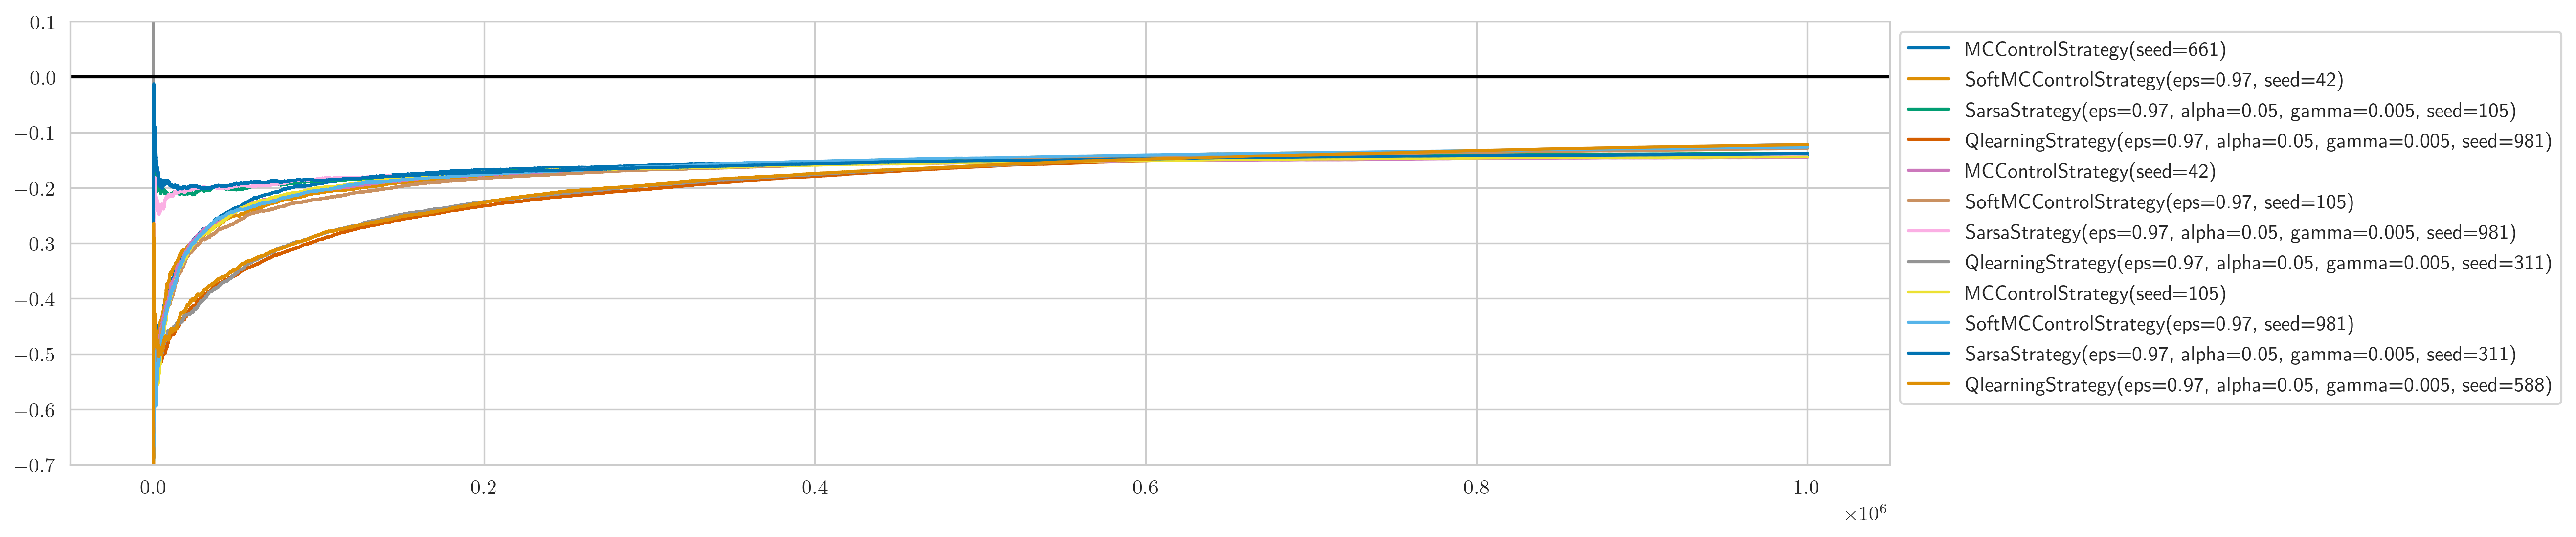

In [42]:
MAX_STRATEGIES = 3
MIN_REWARDS = -0.1

plt.figure(figsize=(16,4))

np.random.seed()
seeds = np.random.randint(1000, size=MAX_STRATEGIES*4)

strats3 = {}
for i in tqdm(range(MAX_STRATEGIES)):
    strategy = MCControlStrategy(seed=seeds[i], n_actions=3)
    run_estimation(strategy, env=gym.make('BlackjackCounting-v0'), display_result=False, strats=strats3)

    strategy = SoftMCControlStrategy(eps=0.97, seed=seeds[i+1], n_actions=3)
    run_estimation(strategy, env=gym.make('BlackjackCounting-v0'), display_result=False, strats=strats3)

    strategy = SarsaStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=seeds[i+2], n_actions=3)
    run_estimation(strategy, env=gym.make('BlackjackCounting-v0'), display_result=False, strats=strats3)

    strategy = QlearningStrategy(eps=0.97, alpha=0.05, gamma=0.005, seed=seeds[i+3], n_actions=3)
    run_estimation(strategy, env=gym.make('BlackjackCounting-v0'), display_result=False, strats=strats3)


df_strats3 = pd.DataFrame(strats3).T \
    .sort_values(by="result",ascending=False)
display(df_strats3)

plt.axhline(y=0.0, color='black')
# plt.xlim((-500, 100000))
plt.ylim((-0.7, 0.1))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Выводы:

- обыграть казино не удалось
- результаты хуже, чем в первых двух частях из-за увеличившегося количества состояний (добавился счетчик)
- Q-learning похоже опять не до конца сошлась
- Q-learning долго запрягает, но после 750К быстро едет